Библиотеки:

In [ ]:
import requests # отправка HTTP-запросов к API hh.ru
import pandas as pd
import time # паузы между запросами (чтобы избежать блокировку со стороны сервера)
from tqdm import tqdm # визуализация отображения прогресса

User-Agent помогает избежать блокировку hh.ru (словарь HEADERS, содержащий заголовок User-Agent имитирует запрос от браузера Chrome)

In [ ]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}


Функция для получения списка ID вакансий по заданному запросу. Возвращает список ID вакансий

In [ ]:
def get_vacancy_ids(search_terms, pages, per_page=100):
    vacancy_ids = set()  # для избежания дубликатов
    for term in search_terms:
        for page in range(pages): # при необходимости можно добавить код региона,например, Москва - 1. Сейчас поиск по всей России
            params = {
                'text': term,
                'per_page': per_page,
                'page': page
            }
            response = requests.get('https://api.hh.ru/vacancies', params=params, headers=HEADERS)

            if response.status_code == 200: # условие проверяет был ли ответ от сервера успешным
                                            # код 200 - успешное выполнение запроса, 404 - страница не найдена, 500 - внутренняя ошибка
                data = response.json()
                vacancy_ids.update([item['id'] for item in data.get('items', [])]) # извлекается ID каждой вакансии

            time.sleep(1) # пауза 1 секуна для избежания блокировки API

    return list(vacancy_ids)

Функция для получения детальной информации о вакансии по её ID. Возвращает словарь с данными вакансии

In [ ]:
def get_vacancy_info(vacancy_id):
    url = f"https://api.hh.ru/vacancies/{vacancy_id}"
    response = requests.get(url, headers=HEADERS)

    if response.status_code == 200:
        vacancy = response.json()

        salary = vacancy.get('salary')
        return {
            'id': vacancy.get('id', ''),
            'name': vacancy.get('name', 'Нет данных'),
            'company': vacancy.get('employer', {}).get('name', 'Нет данных'), # название компании
            'city': vacancy.get('area', {}).get('name', 'Нет данных'), # гоород вакансии
            'key_skills': ', '.join([skill['name'] for skill in vacancy.get('key_skills', [])]),
            'salary_from': salary.get('from') if salary else 0,  # 0, если не указана
            'salary_to': salary.get('to') if salary else 0,
            'experience': vacancy.get('experience', {}).get('name', 'Нет данных'),
            'schedule': vacancy.get('schedule', {}).get('name', 'Нет данных'), # график работы
            'alternate_url': vacancy.get('alternate_url', 'Нет данных')
        }

    return None

Функция для сбора данных по всем вакансиям (сохраняет в Excel). Возвращает DataFrame с данными вакансий

In [ ]:
def collect_vacancies_data(search_terms, pages):
    vacancy_ids = get_vacancy_ids(search_terms, pages)
    all_vacancies = []

    for vacancy_id in tqdm(vacancy_ids, desc="Сбор информации о вакансиях"):
        vacancy_data = get_vacancy_info(vacancy_id)
        if vacancy_data:
            all_vacancies.append(vacancy_data)
        time.sleep(1)  # пауза между запросами

    df = pd.DataFrame(all_vacancies)
    df.to_excel("all_vacancies.xlsx", index=False, engine='openpyxl')
    print(f"Данные успешно сохранены в файл all_vacancies.xlsx. Всего вакансий: {df.shape[0]}")

    return df

Собираем данные для запросов - "Аналитик", "Analyst":

In [ ]:
search_terms = ["Аналитик", "Analyst"]
pages = 20 # нельзя собрать более 2000 вакансий по одному поиску (100 вакансий на странице * 20 страниц = 2000)
df = collect_vacancies_data(search_terms, pages)
print(df.head())

Сбор информации о вакансиях: 100%|██████████| 3150/3150 [1:03:57<00:00,  1.22s/it]


Данные успешно сохранены в файл all_vacancies.xlsx. Всего вакансий: 3150
          id                                              name  \
0  117685242  Аналитик в практику Организационного консалтинга   
1  117129644        Аналитик поддержки продукта Naumen Erudite   
2  112418394                       Системный аналитик (Стажер)   
3  117743231                    Аналитик данных / Data Analyst   
4  116150637                                   Бизнес-аналитик   

                       company             city  \
0                  RusPartners           Москва   
1                       NAUMEN           Москва   
2  Центр финансовых технологий      Владивосток   
3            Saber Interactive  Санкт-Петербург   
4                    Texnomart          Ташкент   

                                          key_skills  salary_from  salary_to  \
0  MS PowerPoint, Английский язык, Подготовка пре...          0.0        0.0   
1                                                             0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3150 non-null   object 
 1   name           3150 non-null   object 
 2   company        3150 non-null   object 
 3   city           3150 non-null   object 
 4   key_skills     3150 non-null   object 
 5   salary_from    2972 non-null   float64
 6   salary_to      2521 non-null   float64
 7   experience     3150 non-null   object 
 8   schedule       3150 non-null   object 
 9   alternate_url  3150 non-null   object 
dtypes: float64(2), object(8)
memory usage: 246.2+ KB


Удаляем дубликаты:

In [ ]:
df.head(20)

,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url
0,117685242,Аналитик в практику Организационного консалтинга,RusPartners,Москва,"MS PowerPoint, Английский язык, Подготовка пре...",0.0,0.0,Нет опыта,Полный день,https://hh.ru/vacancy/117685242
1,117129644,Аналитик поддержки продукта Naumen Erudite,NAUMEN,Москва,,0.0,0.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117129644
2,112418394,Системный аналитик (Стажер),Центр финансовых технологий,Владивосток,"Системный анализ, Бизнес-анализ, Аналитика",0.0,0.0,Нет опыта,Полный день,https://hh.ru/vacancy/112418394
3,117743231,Аналитик данных / Data Analyst,Saber Interactive,Санкт-Петербург,"SQL, Python, Clickhouse, Apache Airflow, Strea...",0.0,0.0,От 3 до 6 лет,Удаленная работа,https://hh.ru/vacancy/117743231
4,116150637,Бизнес-аналитик,Texnomart,Ташкент,,0.0,0.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/116150637
5,116207023,Бизнес-аналитик,Кейтеринбург,Екатеринбург,,0.0,0.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/116207023
6,117150786,Стажер-аналитик (большие данные),Яндекс,Москва,,0.0,0.0,Нет опыта,Полный день,https://hh.ru/vacancy/117150786
7,116529843,Data analyst \ Аналитик данных,Стеллар,Владивосток,"Power BI, Анализ данных, QlikView",0.0,0.0,От 3 до 6 лет,Полный день,https://hh.ru/vacancy/116529843
8,114673345,BI-аналитик,ЛУКОЙЛ,Москва,"Power BI, Apache Airflow, SQL",NaN,150000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/114673345
9,117160808,Middle Data Analyst (Antifraud),Медиапоинт,Москва,"Python, pandas, Numpy, SciPy, Clickhouse, Post...",0.0,0.0,От 3 до 6 лет,Удаленная работа,https://hh.ru/vacancy/117160808


In [ ]:
df = pd.read_excel('all_vacancies.xlsx')

In [ ]:
df[df.salary_from != 0]

,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url
8,114673345,BI-аналитик,ЛУКОЙЛ,Москва,"Power BI, Apache Airflow, SQL",NaN,150000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/114673345
11,117262495,Аналитик,Всм,Москва,"Контроль и анализ ценообразования, Unit-эконом...",80000.0,120000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117262495
13,116537974,Системный аналитик (junior+),ИТРУМ,Ростов-на-Дону,"Системный аналитик, UML, SQL, Функциональные т...",70000.0,80000.0,Нет опыта,Удаленная работа,https://hh.ru/vacancy/116537974
14,117347065,Marketing Data Analyst,Топассистент,Москва,"Python, SQL, MS Excel, Tableau, Бизнес-анализ,...",400000.0,NaN,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117347065
15,116767298,Crypto-аналитик,Евсеев Сергей Владимирович,Москва,"Английский язык, Аналитический склад ума, Анал...",150000.0,450000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/116767298
...,...,...,...,...,...,...,...,...,...,...
3143,115714472,Системный аналитик,Синтека,Санкт-Петербург,"UML, SQL, Системный анализ, XML, BPMN, Аналити...",100000.0,120000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/115714472
3144,117021091,Маркетолог- аналитик,Институт международных экономических связей,Москва,NaN,100000.0,150000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117021091
3145,112757205,Бизнес-аналитик (удалённо),Первый Бит,Москва,"Бизнес-анализ, BPMN, Оптимизация бизнес-процес...",100000.0,170000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/112757205
3147,117159363,Аналитик на маркетплейс Wildberries,MI-MAG,Москва,"ABC-анализ, Управление ассортиментом, Прогнози...",100000.0,200000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117159363


<ipython-input-11-12f02889bfd2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='salary_from', y='experience', inner='box', palette='Dark2')


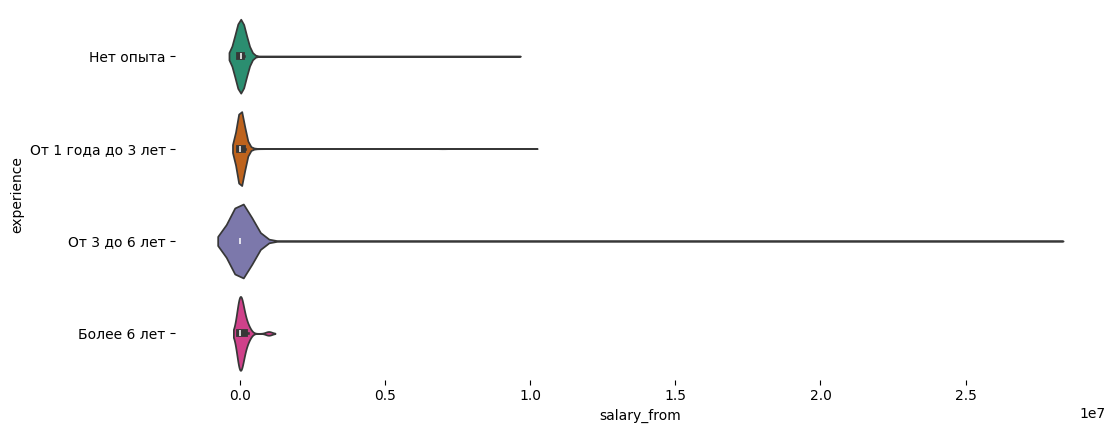

In [ ]:
# @title experience vs salary_from

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['experience'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='salary_from', y='experience', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

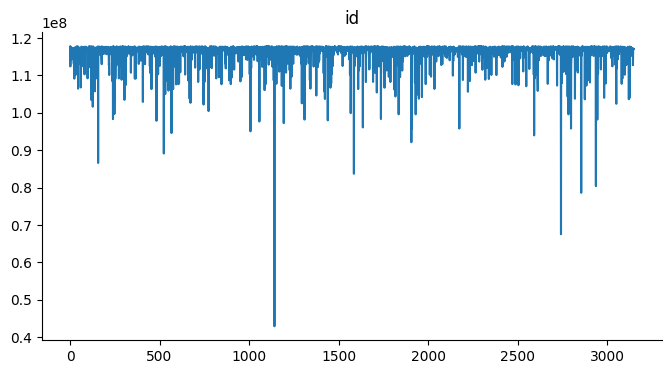

In [ ]:
# @title id

from matplotlib import pyplot as plt
df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

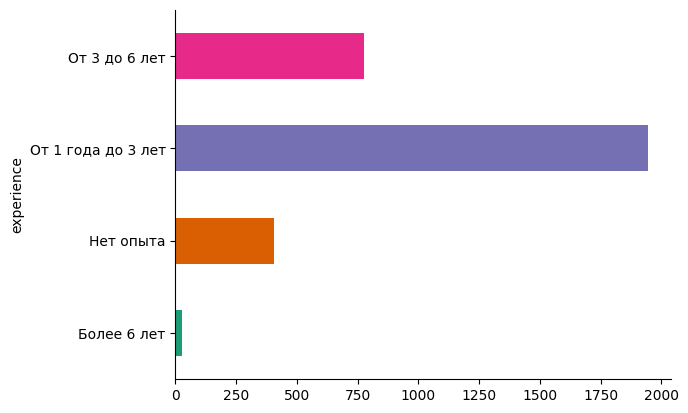

In [ ]:
# @title experience

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('experience').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-8-8b7de4966548>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='id', y='schedule', inner='box', palette='Dark2')


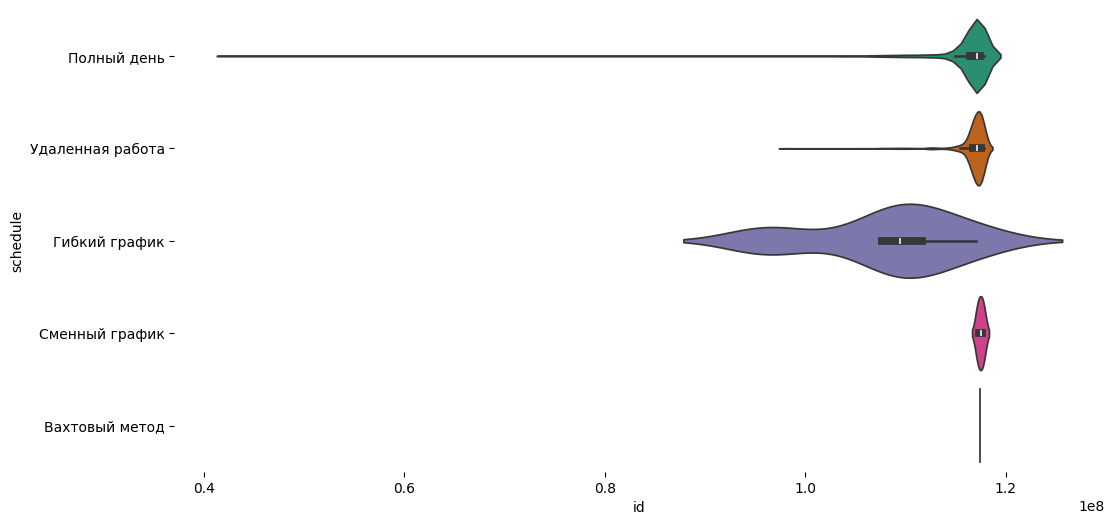

In [ ]:
# @title schedule vs id

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['schedule'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='id', y='schedule', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

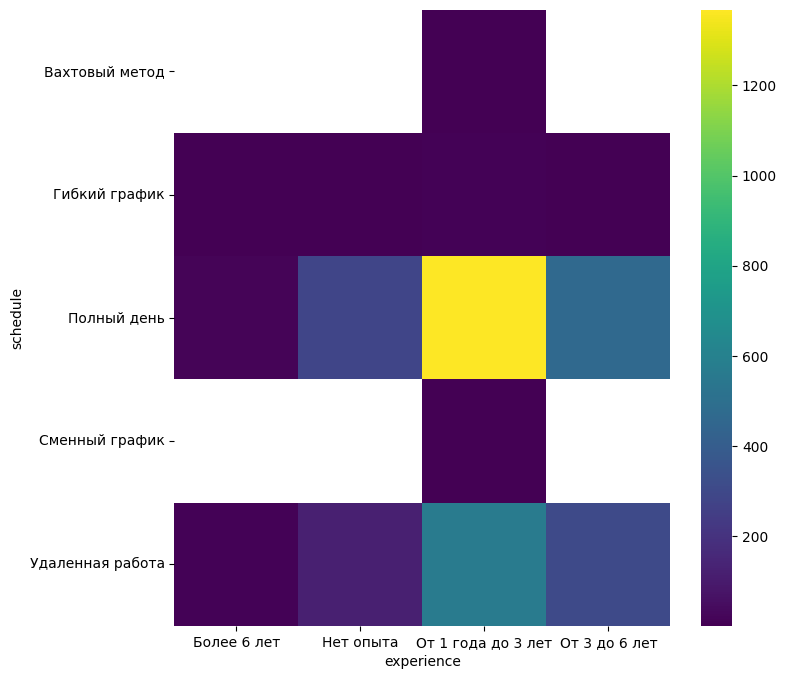

In [ ]:
# @title experience vs schedule

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['schedule'].value_counts()
    for x_label, grp in df.groupby('experience')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('experience')
_ = plt.ylabel('schedule')